In [6]:
! ls -lh
! wc -l PRSA_data_2010.1.1-2014.12.31.csv
! cat PRSA_data_2010.1.1-2014.12.31.csv | head -5

total 2.0M
-rw-rw-r-- 1 jupyter jupyter 1.3K Nov  9 10:54 EDA.ipynb
-rw-rw-r-- 1 jupyter jupyter 2.0M Nov  9 10:49 PRSA_data_2010.1.1-2014.12.31.csv
43825 PRSA_data_2010.1.1-2014.12.31.csv
No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
cat: write error: Broken pipe


## 数据清洗

In [102]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [25]:
def date_parser(x):
    return datetime.strptime(x, '%Y %m %d %H')
input_file = 'PRSA_data_2010.1.1-2014.12.31.csv'
dataset = pd.read_csv(input_file, parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=date_parser)
dataset.drop('No', axis=1, inplace=True)
dataset.index.name = 'date'
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.to_csv('pollution.csv')
print(dataset.tail(5))
dataset.head()

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2014-12-31 19:00:00       8.00  -23 -2.00 1034.00      NW   231.97     0     0
2014-12-31 20:00:00      10.00  -22 -3.00 1034.00      NW   237.78     0     0
2014-12-31 21:00:00      10.00  -22 -3.00 1034.00      NW   242.70     0     0
2014-12-31 22:00:00       8.00  -22 -4.00 1034.00      NW   246.72     0     0
2014-12-31 23:00:00      12.00  -21 -3.00 1034.00      NW   249.85     0     0


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.00,-16,-4.00,1020.00,SE,1.79,0,0
2010-01-02 01:00:00,148.00,-15,-4.00,1020.00,SE,2.68,0,0
2010-01-02 02:00:00,159.00,-11,-5.00,1021.00,SE,3.57,0,0
2010-01-02 03:00:00,181.00,-7,-5.00,1022.00,SE,5.36,1,0
2010-01-02 04:00:00,138.00,-7,-5.00,1022.00,SE,6.25,2,0


## 数据探索、可视化

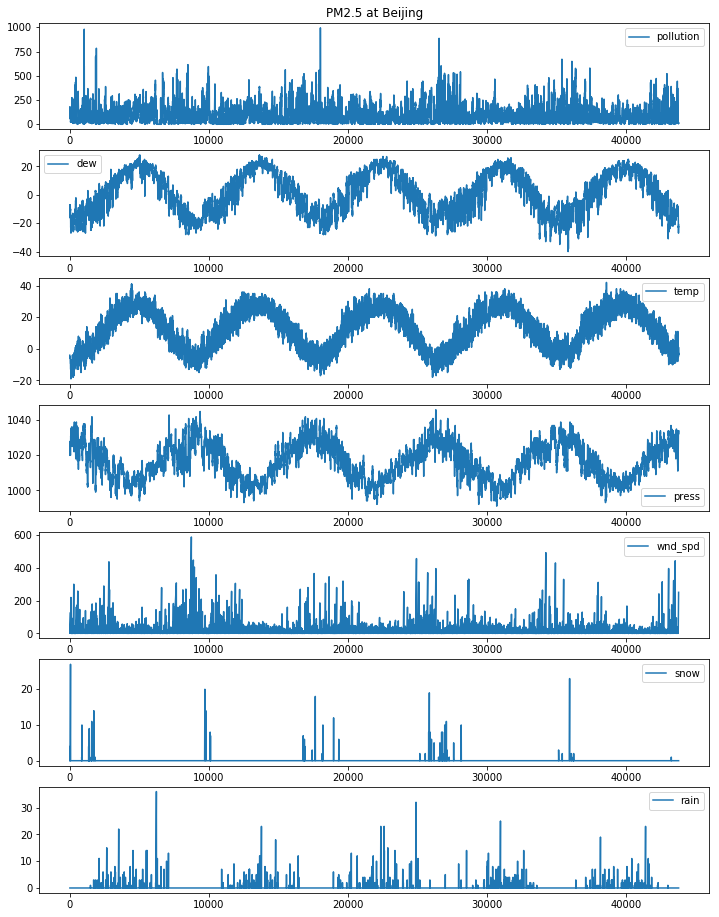

In [52]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
dataset.head()
values = dataset.values
cols = [0, 1, 2, 3, 5, 6, 7]
i = 1

plt.figure(figsize=(12, 16))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, col], label=dataset.columns[col])
    plt.legend()
    if (i == 1):
        plt.title('PM2.5 at Beijing')
#     plt.title(dataset.columns[col], y=0.8, loc='right')
    i += 1

plt.show()

## 特征工程
+ 转换为LSTM模型要求的数据格式
+ 特征选择
+ 归一化


In [75]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [112]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [81]:
df1 = dataset.copy()
values1 = df1.values

# 类型变量 整数编码
encoder = LabelEncoder()
values1[:, 4] = encoder.fit_transform(values1[:, 1])

# 归一化，先确保数据均为数值类型
values1 = values1.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values1)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()

(43799, 9)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.13,0.35,0.25,0.53,0.35,0.00,0.00,0.00,0.15
2,0.15,0.37,0.25,0.53,0.37,0.00,0.00,0.00,0.16
3,0.16,0.43,0.23,0.55,0.43,0.01,0.00,0.00,0.18
4,0.18,0.49,0.23,0.56,0.49,0.01,0.04,0.00,0.14
5,0.14,0.49,0.23,0.56,0.49,0.01,0.07,0.00,0.11


In [85]:
type(df1)
type(values1)
type(reframed)

pandas.core.frame.DataFrame

## 模型构建、训练


### 拆分训练集、测试集

In [115]:
# 拆分训练集、测试集
values2 = reframed.values
n_train_hours = 365 * 24

train = values2[:n_train_hours,:]
test = values2[n_train_hours:, :]
print("train, test shape: ", train.shape, test.shape)

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("train_X, train_y shape: ", train_X.shape, train_y.shape)

# 数据维度转换 [samples, timesteps, features]
# timesteps 的含义， 1与什么有关？ 跟预处理中shift的有关吗？
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

print("train_X, train_y reshaped: ", train_X.shape, train_y.shape)

train, test shape:  (8760, 9) (35039, 9)
train_X, train_y shape:  (8760, 8) (8760,)
train_X, train_y reshaped:  (8760, 1, 8) (8760,)


### 模型设计、构建

In [106]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=False, verbose=2)


Train on 8760 samples, validate on 35039 samples
Epoch 1/51
 - 3s - loss: 0.0557 - val_loss: 0.0822
Epoch 2/51
 - 2s - loss: 0.0385 - val_loss: 0.0993
Epoch 3/51
 - 2s - loss: 0.0255 - val_loss: 0.0868
Epoch 4/51
 - 2s - loss: 0.0202 - val_loss: 0.0704
Epoch 5/51
 - 2s - loss: 0.0171 - val_loss: 0.0504
Epoch 6/51
 - 2s - loss: 0.0156 - val_loss: 0.0299
Epoch 7/51
 - 2s - loss: 0.0152 - val_loss: 0.0247
Epoch 8/51
 - 2s - loss: 0.0152 - val_loss: 0.0189
Epoch 9/51
 - 2s - loss: 0.0152 - val_loss: 0.0164
Epoch 10/51
 - 2s - loss: 0.0152 - val_loss: 0.0149
Epoch 11/51
 - 2s - loss: 0.0150 - val_loss: 0.0142
Epoch 12/51
 - 2s - loss: 0.0148 - val_loss: 0.0150
Epoch 13/51
 - 2s - loss: 0.0151 - val_loss: 0.0144
Epoch 14/51
 - 2s - loss: 0.0148 - val_loss: 0.0139
Epoch 15/51
 - 2s - loss: 0.0150 - val_loss: 0.0141
Epoch 16/51
 - 2s - loss: 0.0149 - val_loss: 0.0137
Epoch 17/51
 - 2s - loss: 0.0150 - val_loss: 0.0140
Epoch 18/51
 - 2s - loss: 0.0150 - val_loss: 0.0141
Epoch 19/51
 - 2s - loss

### 模型训练过程监控

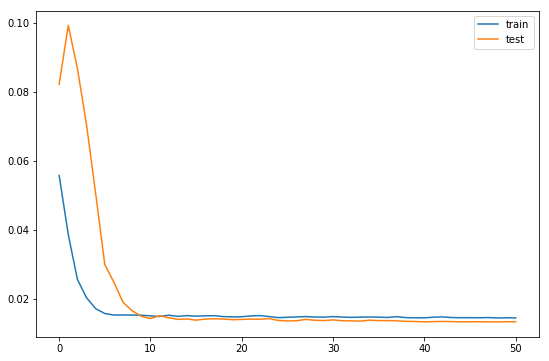

In [107]:
plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 模型评估

In [111]:
yhat = model.predict(test_X)

In [116]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
inv_yhat = np.concatenate((yhat, test_X[:, 1:]),axis=1)

In [117]:
inv_yhat = scaler.inverse_transform(inv_yhat)[:, 0]
test_y_reshape = test_y.reshape(len(test_y), 1)
inv_y = np.concatenate((test_y_reshape, test_X[:, 1:]), axis=1)

y_rescaled = scaler.inverse_transform(inv_y)[:, 0]

In [118]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_yhat, y_rescaled))
print('test RMSE: %.3f' % rmse)

test RMSE: 26.525


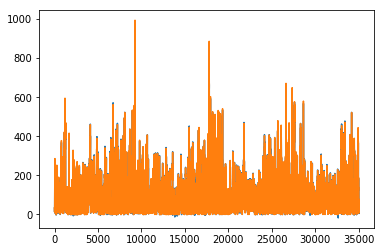

In [119]:
plt.plot(inv_yhat)
plt.plot(y_rescaled)
plt.show()

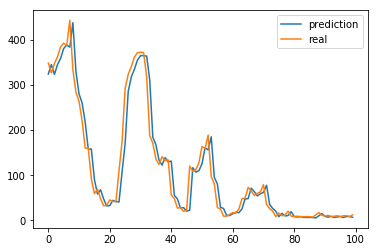

In [121]:
plt.plot(inv_yhat[-100:], label='prediction')
plt.plot(y_rescaled[-100:], label='real')
plt.legend()
plt.show()